
# Retail Analysis Behavior & Segmentation Analysis
This notebook reproduces the pipeline that cleaned the **Online Retail** dataset, generated EDA tables/plots, and built an **RFM** customer segmentation.

**Inputs**
- `Online Retail.xlsx` 

**Outputs **
- `retail_clean.csv`
- `eda_top_products.csv`
- `eda_monthly_revenue.csv`
- `rfm_table.csv`
- `monthly_revenue.png`, `top_products.png`, `order_value_distribution.png`

 


In [16]:

# === Parameters ===
from pathlib import Path

DATA_PATH = Path("Online Retail.xlsx")     
OUT_DIR   = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("Data path:", DATA_PATH.resolve())
print("Output dir:", OUT_DIR.resolve())


Data path: C:\Users\kaust\Documents\Online Retail.xlsx
Output dir: C:\Users\kaust\Documents\outputs


In [17]:

# Imports & environment 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("pandas:", pd.__version__)
print("numpy:", np.__version__)


pandas: 2.2.3
numpy: 2.1.3


In [18]:

#  Load Data 
assert DATA_PATH.exists(), f"Could not find input file at: {DATA_PATH}"
df = pd.read_excel(DATA_PATH)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Cleaning

In [19]:

# Drop rows with missing CustomerID (needed for RFM)
df = df.dropna(subset=["CustomerID"])

# Remove cancellations (InvoiceNo starting with 'C')
df = df[~df["InvoiceNo"].astype(str).str.startswith("C", na=False)]

# Keep strictly positive quantities and unit prices
if "Quantity" in df.columns:
    df = df[df["Quantity"] > 0]
if "UnitPrice" in df.columns:
    df = df[df["UnitPrice"] > 0]

# Ensure InvoiceDate is datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# TotalPrice
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Drop duplicates
df = df.drop_duplicates()

df_clean_path = OUT_DIR / "retail_clean.csv"
df.to_csv(df_clean_path, index=False)
df.shape, df_clean_path


((392692, 9), WindowsPath('outputs/retail_clean.csv'))

## Quick sanity checks

In [20]:

# Structure & missing values
display(df.info())
display(df.select_dtypes(include='number').describe())
df.isnull().sum().sort_values(ascending=False).head(10)


<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  float64       
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.0+ MB


None

,Quantity,UnitPrice,CustomerID,TotalPrice
count,392692.000000,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865,22.631500
std,180.492832,22.241836,1713.539549,311.099224
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,13955.000000,4.950000
50%,6.000000,1.950000,15150.000000,12.450000
75%,12.000000,3.750000,16791.000000,19.800000
max,80995.000000,8142.750000,18287.000000,168469.600000


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

## EDA: Top products & Monthly revenue

In [21]:

# Top products by quantity and revenue
top_qty = (
    df.groupby("StockCode", as_index=False)["Quantity"]
      .sum()
      .sort_values("Quantity", ascending=False)
      .head(10)
)
top_rev = (
    df.groupby("StockCode", as_index=False)["TotalPrice"]
      .sum()
      .sort_values("TotalPrice", ascending=False)
      .head(10)
)

top_products = pd.merge(top_qty, top_rev, on="StockCode", how="outer").fillna(0)
top_products_path = OUT_DIR / "eda_top_products.csv"
top_products.to_csv(top_products_path, index=False)
top_products.head(10)


,StockCode,Quantity,TotalPrice
0,21212,33670.0,0.00
1,22197,49160.0,0.00
2,22423,0.0,142264.75
3,22492,26076.0,0.00
4,23084,27153.0,51251.24
5,23166,77916.0,81416.73
6,23843,80995.0,168469.60
7,47566,0.0,68785.23
8,84077,54319.0,0.00
9,84879,35263.0,56413.03


In [22]:

# Monthly revenue
df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M").dt.to_timestamp()
monthly_revenue = (
    df.groupby("InvoiceMonth", as_index=False)["TotalPrice"]
      .sum()
      .rename(columns={"TotalPrice": "Revenue"})
      .sort_values("InvoiceMonth")
)
monthly_path = OUT_DIR / "eda_monthly_revenue.csv"
monthly_revenue.to_csv(monthly_path, index=False)
monthly_revenue.head(12)


,InvoiceMonth,Revenue
0,2010-12-01,570422.730
1,2011-01-01,568101.310
2,2011-02-01,446084.920
3,2011-03-01,594081.760
4,2011-04-01,468374.331
5,2011-05-01,677355.150
6,2011-06-01,660046.050
7,2011-07-01,598962.901
8,2011-08-01,644051.040
9,2011-09-01,950690.202


## Plots

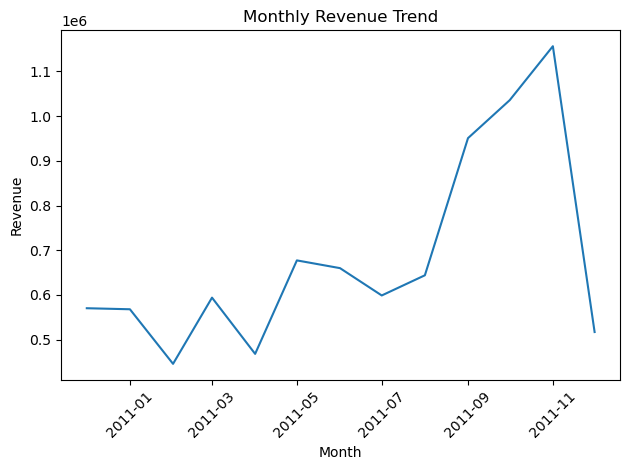

WindowsPath('outputs/monthly_revenue.png')

In [23]:

# Monthly revenue line plot
plt.figure()
plt.plot(monthly_revenue["InvoiceMonth"], monthly_revenue["Revenue"])
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
monthly_plot = OUT_DIR / "monthly_revenue.png"
plt.savefig(monthly_plot, dpi=150)
plt.show()
monthly_plot


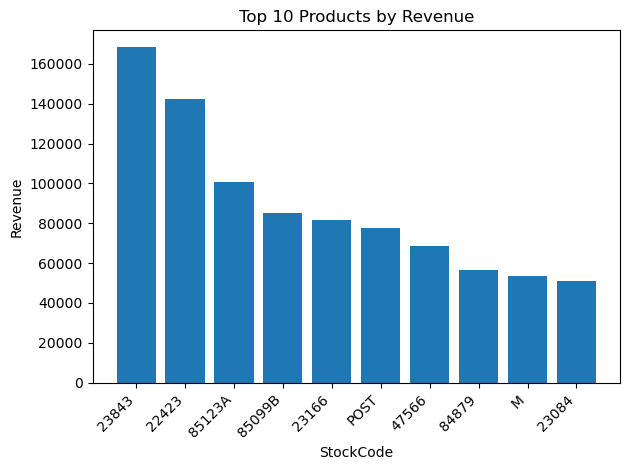

WindowsPath('outputs/top_products.png')

In [24]:

# Top products (by revenue) bar chart
plt.figure()
plt.bar(top_rev["StockCode"].astype(str), top_rev["TotalPrice"])
plt.title("Top 10 Products by Revenue")
plt.xlabel("StockCode")
plt.ylabel("Revenue")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
top_products_plot = OUT_DIR / "top_products.png"
plt.savefig(top_products_plot, dpi=150)
plt.show()
top_products_plot


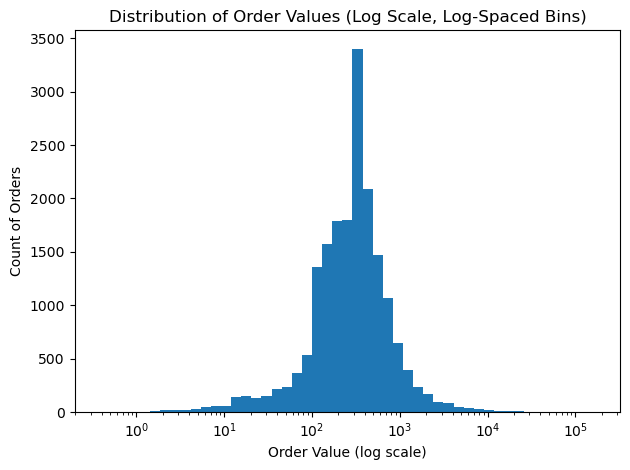

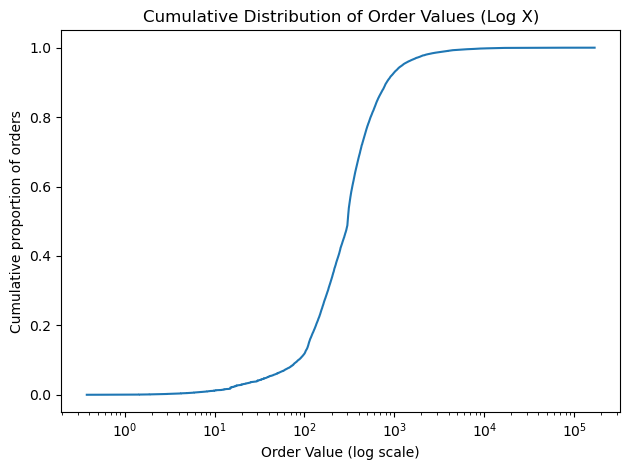

In [25]:

# Distribution of order values (sum TotalPrice per InvoiceNo)
import numpy as np

order_values = df.groupby("InvoiceNo")["TotalPrice"].sum()

# Keep only positive values for log scale
ov = order_values[order_values > 0]


# ov = ov[ov < ov.quantile(0.995)]

# Build log-spaced bins from min>0 to max
bins = np.logspace(np.log10(ov.min()), np.log10(ov.max()), 50)

plt.figure()
plt.hist(ov, bins=bins)
plt.xscale('log')
plt.title("Distribution of Order Values (Log Scale, Log-Spaced Bins)")
plt.xlabel("Order Value (log scale)")
plt.ylabel("Count of Orders")
plt.tight_layout()
plt.savefig(OUT_DIR / "order_value_distribution_log_bins.png", dpi=150)
plt.show()

vals = np.sort(ov.values)
cdf = np.arange(1, len(vals)+1) / len(vals)

plt.figure()
plt.plot(vals, cdf)
plt.xscale('log')
plt.title("Cumulative Distribution of Order Values (Log X)")
plt.xlabel("Order Value (log scale)")
plt.ylabel("Cumulative proportion of orders")
plt.tight_layout()
plt.savefig(OUT_DIR / "order_value_cdf_logx.png", dpi=150)
plt.show()



## RFM Analysis

In [26]:

# Snapshot date as max InvoiceDate + 1 day
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,  # Recency (days since last purchase)
    "InvoiceNo": "nunique",                                   # Frequency (distinct invoices)
    "TotalPrice": "sum"                                       # Monetary (total spend)
}).reset_index()

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

# Quintile scores (1..5); for Recency we reverse so 5 is most recent / best
rfm["R_quintile"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]).astype(int)
rfm["F_quintile"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_quintile"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)

rfm["RFM_Score"] = rfm["R_quintile"].astype(str) + rfm["F_quintile"].astype(str) + rfm["M_quintile"].astype(str)

def segment(row):
    if row["R_quintile"] >= 4 and row["F_quintile"] >= 4 and row["M_quintile"] >= 4:
        return "Champions"
    if row["R_quintile"] >= 4 and row["F_quintile"] >= 3:
        return "Loyal"
    if row["R_quintile"] <= 2 and row["F_quintile"] >= 4:
        return "At Risk"
    if row["R_quintile"] <= 2 and row["F_quintile"] <= 2:
        return "Dormant"
    return "Potential"

rfm["Segment"] = rfm.apply(segment, axis=1)

rfm_path = OUT_DIR / "rfm_table.csv"
rfm.to_csv(rfm_path, index=False)
rfm.head(20)


,CustomerID,Recency,Frequency,Monetary,R_quintile,F_quintile,M_quintile,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,115,Dormant
1,12347.0,2,7,4310.00,5,5,5,555,Champions
2,12348.0,75,4,1797.24,2,4,4,244,At Risk
3,12349.0,19,1,1757.55,4,1,4,414,Potential
4,12350.0,310,1,334.40,1,1,2,112,Dormant
5,12352.0,36,8,2506.04,3,5,5,355,Potential
6,12353.0,204,1,89.00,1,1,1,111,Dormant
7,12354.0,232,1,1079.40,1,1,4,114,Dormant
8,12355.0,214,1,459.40,1,1,2,112,Dormant
9,12356.0,23,3,2811.43,4,3,5,435,Loyal


In [27]:
                                  ##########################################################